# API & LangGraph


## 0. 환경 설정

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("API-LangGraph-Test")

LangSmith 추적을 시작합니다.
[프로젝트명]
API-LangGraph-Test


## 1. State 정의

In [3]:
from typing import Annotated, TypedDict, Any
from langgraph.graph.message import add_messages

# .env에 정의된 API 사용 여부를 고려해 상태를 확장합니다.
class GraphState(TypedDict):
    question: Annotated[str, "Question"]  # 입력 질문

    openai_answer: Annotated[str | None, "OpenAI 응답"]
    gemini_answer: Annotated[str | None, "Google Gemini 응답"]
    anthropic_answer: Annotated[str | None, "Anthropic Claude 응답"]
    upstage_answer: Annotated[str | None, "Upstage 응답"]
    perplexity_answer: Annotated[str | None, "Perplexity 응답"]
    tavily_search: Annotated[str | None, "Tavily 검색 결과"]

    answer: Annotated[dict[str, Any] | None, "최종 답변"]

    api_status: Annotated[dict[str, Any] | None, "API별 호출 메타데이터"]

    openai_status: Annotated[dict[str, Any] | None, "OpenAI 호출 상태"]
    gemini_status: Annotated[dict[str, Any] | None, "Gemini 호출 상태"]
    anthropic_status: Annotated[dict[str, Any] | None, "Anthropic 호출 상태"]
    upstage_status: Annotated[dict[str, Any] | None, "Upstage 호출 상태"]
    perplexity_status: Annotated[dict[str, Any] | None, "Perplexity 호출 상태"]
    
    messages: Annotated[list, add_messages]  # 메시지 기록


In [4]:
from collections.abc import Mapping


def build_status_from_response(response: Any, default_status: int = 200, detail: str = "success") -> dict[str, Any]:
    """LLM 응답 객체에서 상태 정보를 추출합니다."""
    metadata: Mapping[str, Any] | None = getattr(response, "response_metadata", None)
    metadata = metadata or {}
    status = metadata.get("status_code") or metadata.get("status") or metadata.get("http_status")
    detail_text = metadata.get("finish_reason") or metadata.get("reason") or detail
    return {"status": status or default_status, "detail": detail_text}


def build_status_from_error(error: Exception) -> dict[str, Any]:
    """예외 객체에서 상태 코드를 유추합니다."""
    status = getattr(error, "status_code", None)
    if status is None:
        response = getattr(error, "response", None)
        if response is not None:
            status = getattr(response, "status_code", None)
    return {"status": status or "error", "detail": str(error)}


def format_response_message(label: str, payload: Any) -> tuple[str, str]:
    """메시지 로그에 기록할 튜플을 생성합니다."""
    return ("assistant", f"[{label}] {payload}")


## 2. 노드(Node) 정의

In [5]:
def init_question(state: GraphState) -> GraphState:
    """그래프 시작 시 질문을 검증하고 기본 상태를 세팅합니다."""
    question = state.get("question")
    if not question:
        raise ValueError("질문이 비어 있습니다.")

    return GraphState(
        question=question,
        messages=[("user", question)],
        api_status={},
    )


In [6]:
from langchain_openai import ChatOpenAI


def call_openai(state: GraphState) -> GraphState:
    question = state["question"]

    llm = ChatOpenAI(
        model="gpt-5-nano"
    )
    try:
        response = llm.invoke(question)
        content = response.content if hasattr(response, "content") else str(response)
        status = build_status_from_response(response)
        return GraphState(
            openai_answer=content,
            openai_status=status,
            messages=[format_response_message("OpenAI", response)],
        )
    except Exception as exc:
        status = build_status_from_error(exc)
        return GraphState(
            openai_status=status,
            messages=[format_response_message("OpenAI 오류", exc)],
        )


In [7]:
from langchain_google_genai import ChatGoogleGenerativeAI


def call_gemini(state: GraphState) -> GraphState:
    question = state["question"]

    llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash-lite",
        temperature=0,
    )
    try:
        response = llm.invoke(question)
        content = response.content if hasattr(response, "content") else str(response)
        status = build_status_from_response(response)
        return GraphState(
            gemini_answer=content,
            gemini_status=status,
            messages=[format_response_message("Gemini", response)],
        )
    except Exception as exc:
        status = build_status_from_error(exc)
        return GraphState(
            gemini_status=status,
            messages=[format_response_message("Gemini 오류", exc)],
        )


In [8]:
from langchain_anthropic import ChatAnthropic


def call_anthropic(state: GraphState) -> GraphState:
    question = state["question"]

    llm = ChatAnthropic(
        model="claude-haiku-4-5-20251001",
        temperature=0,
    )
    try:
        response = llm.invoke(question)
        content = response.content if hasattr(response, "content") else str(response)
        status = build_status_from_response(response)
        return GraphState(
            anthropic_answer=content,
            anthropic_status=status,
            messages=[format_response_message("Anthropic", response)],
        )
    except Exception as exc:
        status = build_status_from_error(exc)
        return GraphState(
            anthropic_status=status,
            messages=[format_response_message("Anthropic 오류", exc)],
        )


In [9]:
from langchain_upstage import ChatUpstage


def call_upstage(state: GraphState) -> GraphState:
    question = state["question"]

    llm = ChatUpstage(
        model="solar-mini",
    )
    try:
        response = llm.invoke(question)
        content = response.content if hasattr(response, "content") else str(response)
        status = build_status_from_response(response)
        return GraphState(
            upstage_answer=content,
            upstage_status=status,
            messages=[format_response_message("Upstage", response)],
        )
    except Exception as exc:
        status = build_status_from_error(exc)
        return GraphState(
            upstage_status=status,
            messages=[format_response_message("Upstage 오류", exc)],
        )


In [10]:
from langchain_teddynote.models import ChatPerplexity


def call_perplexity(state: GraphState) -> GraphState:
    question = state["question"]

    llm = ChatPerplexity(
        model="sonar",
        temperature=0.2,
        top_p=0.9,
        search_domain_filter=["perplexity.ai"],
        return_images=False,
        return_related_questions=True,
        # search_recency_filter="month",
        top_k=0,
        stream=False,
    )

    try:
        response = llm.invoke(question)
        content = response.content if hasattr(response, "content") else str(response)
        status = build_status_from_response(response)
        return GraphState(
            perplexity_answer=content,
            perplexity_status=status,
            messages=[format_response_message("Perplexity", response)],
        )
    except Exception as exc:
        status = build_status_from_error(exc)
        return GraphState(
            perplexity_status=status,
            messages=[format_response_message("Perplexity 오류", exc)],
        )


In [11]:
# from langchain_teddynote.tools.tavily import TavilySearch

# def call_tavily(state: GraphState) -> GraphState:
#     question = state["question"]

#     tavily_tool = TavilySearch()
#     response = tavily_tool.search(
    #     query=question,  # 검색 쿼리
    #     topic="news",  # 일반 주제
    #     days=1,  # 최근 1일 내 검색
    #     max_results=3,  # 최대 검색 결과
    #     format_output=True,  # 결과 포맷팅
    # )

#     return GraphState(tavily_search=response)


In [12]:
LLM_FIELDS = [
    ("openai_answer", "OpenAI", "openai_status"),
    ("gemini_answer", "Gemini", "gemini_status"),
    ("anthropic_answer", "Anthropic", "anthropic_status"),
    ("perplexity_answer", "Perplexity", "perplexity_status"),
    ("upstage_answer", "Upstage", "upstage_status"),
    # ("tavily_search", "Tavily Search", None),
]


def summarize_answers(state: GraphState) -> GraphState:
    """노드별 응답을 모아 최종 답변과 상태 요약을 생성합니다."""
    answers: dict[str, Any] = {}
    api_status: dict[str, Any] = {}

    for answer_key, label, status_key in LLM_FIELDS:
        answers[label] = state.get(answer_key)
        if status_key is not None:
            status_value = state.get(status_key)
            if status_value is not None:
                api_status[label] = status_value

    return GraphState(
        answer=answers,
        api_status=api_status,
    )


## 3. 그래프 생성

In [13]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("init_question", init_question)
workflow.add_node("call_openai", call_openai)
workflow.add_node("call_gemini", call_gemini)
workflow.add_node("call_anthropic", call_anthropic)
workflow.add_node("call_upstage", call_upstage)
workflow.add_node("call_perplexity", call_perplexity)
workflow.add_node("summarize_answers", summarize_answers)

# 엣지 정의
workflow.add_edge("init_question", "call_openai")
workflow.add_edge("init_question", "call_gemini")
workflow.add_edge("init_question", "call_anthropic")
workflow.add_edge("init_question", "call_upstage")
workflow.add_edge("init_question", "call_perplexity")

workflow.add_edge("call_openai", "summarize_answers")
workflow.add_edge("call_gemini", "summarize_answers")
workflow.add_edge("call_anthropic", "summarize_answers")
workflow.add_edge("call_upstage", "summarize_answers")
workflow.add_edge("call_perplexity", "summarize_answers")
workflow.add_edge("summarize_answers", END)  # 답변 -> 종료

# 그래프 진입점 설정
workflow.set_entry_point("init_question")

# 체크포인터 설정
memory = MemorySaver()

# 컴파일
app = workflow.compile(checkpointer=memory)

컴파일한 그래프를 시각화 합니다.

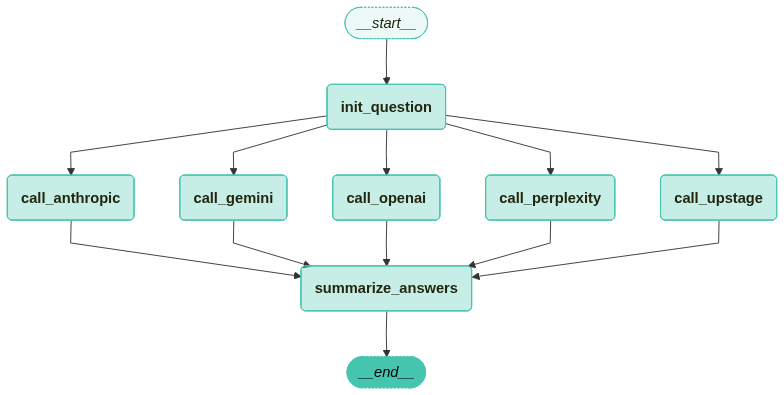

In [14]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

## 4. 그래프 실행

- `config` 파라미터는 그래프 실행 시 필요한 설정 정보를 전달합니다.
- `recursion_limit`: 그래프 실행 시 재귀 최대 횟수를 설정합니다.
- `inputs`: 그래프 실행 시 필요한 입력 정보를 전달합니다.

In [15]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, stream_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = GraphState(question="크리스탈 버전에서 학습장치는 어떻게 얻지?")

# 그래프 실행
invoke_graph(app, inputs, config)

ModuleNotFoundError: No module named 'langchain.agents.output_parsers'

In [ ]:
# 그래프를 스트리밍 출력
# stream_graph(app, inputs, config)

In [ ]:
outputs = app.get_state(config).values

print(f"Question: {outputs['question']}")
print("===" * 20)

print("Answers by model:")
for model, answer in (outputs.get("answer") or {}).items():
    display_answer = answer if answer is not None else "응답 없음"
    print(f"- {model}: {display_answer}")

print("===" * 20)
print("API status:")
for model, status in (outputs.get("api_status") or {}).items():
    code = status.get("status") if isinstance(status, dict) else status
    detail = status.get("detail") if isinstance(status, dict) else ""
    detail_text = f" ({detail})" if detail else ""
    print(f"- {model}: {code}{detail_text}")

print("===" * 20)
print("Messages:")
for message in outputs.get("messages", []):
    if isinstance(message, tuple) and len(message) == 2:
        role, content = message
        print(f"{role}: {content}")
    else:
        print(message)


Question: AI를 90년대의 어떤 영화 장르로 비유해 1문장으로 설명해줘.
Answers by model:
- OpenAI: AI를 90년대 사이버펑크 영화로 비유하자면, 인간과 기계가 얽히고 현실과 가상이 뒤섯인 도시에서 기술의 가능성과 위험이 함께 흐르는 디지털 느와르다.
- Gemini: AI는 90년대 SF 영화의 '매트릭스'처럼 현실과 가상 세계의 경계를 허물며 새로운 가능성과 위험을 동시에 제시하는 존재입니다.
- Anthropic: AI는 90년대의 **SF 스릴러**처럼, 미지의 기술이 인류의 삶을 급격히 변화시키면서 무한한 가능성과 불안감을 동시에 안겨주는 존재다.
- Perplexity: AI는 90년대의 **사이버펑크 영화**처럼, 미래의 기술이 인간의 삶을 근본적으로 변화시킬 거대한 힘으로 등장하면서 그 가능성과 위험성 사이에서 우리를 불안하게 만드는 존재다.
- Upstage: AI는 90년대의 "사이버펑크" 영화 장르와 같으며, 미래지향적이고 혁신적이지만 동시에 복잡성과 불확실성을 내포하고 있습니다.
API status:
- OpenAI: 200 (stop)
- Gemini: 200 (STOP)
- Anthropic: 200 (success)
- Perplexity: 200 (stop)
- Upstage: 200 (stop)
Messages:
content='AI를 90년대의 어떤 영화 장르로 비유해 1문장으로 설명해줘.' additional_kwargs={} response_metadata={} id='30d7b240-ed7e-468e-8598-4c6d5e23b64c'
content="[Anthropic] content='AI는 90년대의 **SF 스릴러**처럼, 미지의 기술이 인류의 삶을 급격히 변화시키면서 무한한 가능성과 불안감을 동시에 안겨주는 존재다.' additional_kwargs={} response_metadata={'id': 'msg_016pXoRQZoRhUYy68ucpL3zW', 'model': 'claude

In [ ]:
outputs

{'question': 'AI를 90년대의 어떤 영화 장르로 비유해 1문장으로 설명해줘.',
 'openai_answer': 'AI를 90년대 사이버펑크 영화로 비유하자면, 인간과 기계가 얽히고 현실과 가상이 뒤섯인 도시에서 기술의 가능성과 위험이 함께 흐르는 디지털 느와르다.',
 'gemini_answer': "AI는 90년대 SF 영화의 '매트릭스'처럼 현실과 가상 세계의 경계를 허물며 새로운 가능성과 위험을 동시에 제시하는 존재입니다.",
 'anthropic_answer': 'AI는 90년대의 **SF 스릴러**처럼, 미지의 기술이 인류의 삶을 급격히 변화시키면서 무한한 가능성과 불안감을 동시에 안겨주는 존재다.',
 'upstage_answer': 'AI는 90년대의 "사이버펑크" 영화 장르와 같으며, 미래지향적이고 혁신적이지만 동시에 복잡성과 불확실성을 내포하고 있습니다.',
 'perplexity_answer': 'AI는 90년대의 **사이버펑크 영화**처럼, 미래의 기술이 인간의 삶을 근본적으로 변화시킬 거대한 힘으로 등장하면서 그 가능성과 위험성 사이에서 우리를 불안하게 만드는 존재다.',
 'answer': {'OpenAI': 'AI를 90년대 사이버펑크 영화로 비유하자면, 인간과 기계가 얽히고 현실과 가상이 뒤섯인 도시에서 기술의 가능성과 위험이 함께 흐르는 디지털 느와르다.',
  'Gemini': "AI는 90년대 SF 영화의 '매트릭스'처럼 현실과 가상 세계의 경계를 허물며 새로운 가능성과 위험을 동시에 제시하는 존재입니다.",
  'Anthropic': 'AI는 90년대의 **SF 스릴러**처럼, 미지의 기술이 인류의 삶을 급격히 변화시키면서 무한한 가능성과 불안감을 동시에 안겨주는 존재다.',
  'Perplexity': 'AI는 90년대의 **사이버펑크 영화**처럼, 미래의 기술이 인간의 삶을 근본적으로 변화시킬 거대한 힘으로 등장하면서 그 가능성과 위험성 사이에서 우리를 불안하게 만드는 존재다.',
  'Upstage': 'A